# Regression step from NLCD data explained: vectorized raster

**Note: previously `return_weights_from_regression` use to follow these functions of this notebook which is an alternative way of the current implementation that uses `rasterstats` given by `fast_append_profile_gdf` which is faster than `append_profile_gdf` we present here. However, we present here as for dicdatic purpose what happens under the hood of this step. Small differences in the coefficient of `fast_append_profile_gdf` and `append_profile_gdf` may arise.**

In this notebook, it is explained how internally the functions of `vectorized_raster_interpolation.py` works with the processing of the regression step in the notebook `vectorized_raster_example`. We recommend to take a look at this mentioned notebook before, since there is the explanation of how to get the data and files used for this current notebook. Some of the functionalities draw inspiration from https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html.

First, let's read the functions needed:

In [1]:
from tobler.vectorized_raster_interpolation import *

Then, we read the National Land Cover data of Pennsylvania:

In [2]:
import rasterio
from rasterio.plot import show
import osmnx as ox
from rasterio.mask import mask
from fiona.crs import from_epsg
import pycrs
import pickle

import numpy as np
import geopandas as gpd

# Instructions of how to get this file in vectorized_raster_example.ipynb
filepath = '~/NLCD2011_LC_Pennsylvania.tif'
penn_raster = rasterio.open(filepath)

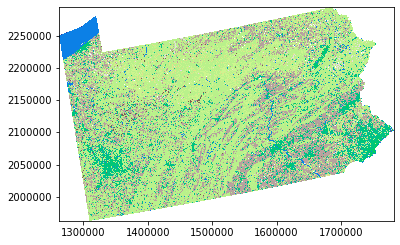

In [3]:
show(penn_raster, cmap = 'terrain')

Then, we read the corresponding GeoDataFrame and add some population on it.

In [4]:
import pandas as pd

filepath = '~/data/LTDB_Std_2010_fullcount.csv'

census_2010 = pd.read_csv(filepath, encoding = "ISO-8859-1", sep = ",")

# This file can be download here: https://drive.google.com/open?id=1gWF0OCn6xuR_WrEj7Ot2jY6KI2t6taIm
with open('tracts_US.pkl', 'rb') as input:
    map_gpd = pickle.load(input)

df = census_2010.loc[(census_2010.state == "PA")]

map_gpd['INTGEOID10'] = pd.to_numeric(map_gpd["GEOID10"])
merged_gdf = map_gpd.merge(df, left_on = 'INTGEOID10', right_on = 'tractid')
merged_gdf.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,COUNTY_ID,county_id2,COUNTYNS10,NAME10_COU,GEOID_MSA,...,a15hsp10,a60hsp10,ageasn10,a15asn10,a60asn10,agentv10,a15ntv10,a60ntv10,GlobD10,GlobG10
0,42,001,030800,42001030800,308,42001,42001,1213656,Adams,23900,...,132,14,60,14,5,6,1,2,w,White
1,42,001,030400,42001030400,304,42001,42001,1213656,Adams,23900,...,164,24,23,7,0,11,1,2,wh,Single immig
2,42,001,030300,42001030300,303,42001,42001,1213656,Adams,23900,...,204,15,11,4,1,15,5,2,wh,Single immig
3,42,001,030500,42001030500,305,42001,42001,1213656,Adams,23900,...,155,18,8,1,2,4,0,2,wh,Single immig
4,42,001,030700,42001030700,307,42001,42001,1213656,Adams,23900,...,167,19,42,6,7,3,0,1,w,White


### How to build the geography profile of the area of a specific polygon

Let's choose a specific tract and illustrate what is happening under the hood of the functions:

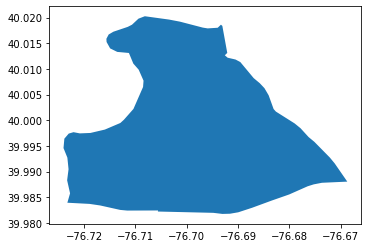

In [5]:
specific_polygon = merged_gdf[merged_gdf.GEOID10 == '42133010120']
specific_polygon.plot()

The first, and foremost, thing to notice is that this polygon and the previous raster data from NLCD are in different scale, i.e., they are in different projections. Therefore, we can project the current polygon to the same Coordinate Reference System (CRS) of the raster:

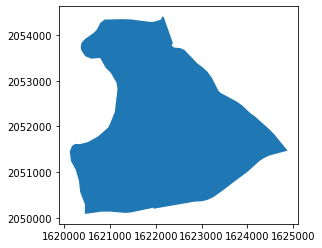

In [6]:
specific_polygon.crs = {'init': 'epsg:4326'} # This is step is only to highlight that the polygon have some default projection
specific_polygon_projected = specific_polygon.to_crs(crs = penn_raster.crs.data)
specific_polygon_projected.plot()

Now, what we can do is to use the bounding box of this projected polygon and clip the original raster with these coordinates with the function `mask` of rasterio. In this call, you get the original pixel values and the corresponding Affline transformation (https://github.com/sgillies/affine) that relates each pixel with the original projection. 

In [7]:
coords = getFeatures(specific_polygon_projected)
out_img, out_transform = mask(dataset = penn_raster, shapes = coords, crop = True)
out_img

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [8]:
type(out_transform)

affine.Affine

One of the most important functions is the `create_lon_lat` where you pass both object previously constructed and it returns the latitude and longitude of each pixel

In [9]:
help(create_lon_lat)

Help on function create_lon_lat in module tobler.vectorized_raster_interpolation:

create_lon_lat(out_img, out_transform)
    Function that returns a tuple of longitudes and latitudes from numpy array and Affline
    
    Parameters
    ----------
    
    out_img       : numpy array generated by the mask function (first tuple element)
    
    out_transform : Affline transformation generated by the mask function (second tuple element)
    
    Notes
    -----
    
    Inside the inner loop there is an important thing to consider which is that the dimensions
    out_img is (1, lat, lon), whereas the Affline transformation gives (lon, lat) (or, accordingly
    to their documentation is (x,y)) that is why it is swapped the indexes. 
    Also, note the repetition in the indexes of (j, j) and (i, i) inside the inner loop.



In [10]:
lons, lats = create_lon_lat(out_img, out_transform)

We can use this to build a correspondence table that relates each pixel value and the corresponding latitude and longitude. We can also built a geometry point with the corresponding values as it is done below.

In [11]:
from shapely.geometry import Point

data = {'lons': np.ndarray.flatten(lons).round().astype(int).tolist(), 
        'lats': np.ndarray.flatten(lats).round().astype(int).tolist(),
        'pixel_value': np.ndarray.flatten(out_img)}
polygon_summary = pd.DataFrame.from_dict(data)
polygon_summary['geometry'] = list(zip(polygon_summary.lons, polygon_summary.lats))
polygon_summary['geometry'] = polygon_summary.geometry.apply(Point)
polygon_summary = gpd.GeoDataFrame(polygon_summary)
polygon_summary.head()

,lons,lats,pixel_value,geometry
0,1620105,2054415,255,POINT (1620105 2054415)
1,1620135,2054415,255,POINT (1620135 2054415)
2,1620165,2054415,255,POINT (1620165 2054415)
3,1620195,2054415,255,POINT (1620195 2054415)
4,1620225,2054415,255,POINT (1620225 2054415)


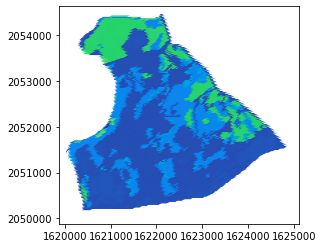

In [12]:
polygon_summary.plot(column = 'pixel_value', cmap = 'terrain')

All these steps happen inside the function called `return_area_profile` where the result is the profile of this specific polygon, where each count of each type is illustrated by a variable named 'Type_' and then the code:

In [13]:
profiled_polygon = return_area_profile(specific_polygon, penn_raster)
profiled_polygon

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,COUNTY_ID,county_id2,COUNTYNS10,NAME10_COU,GEOID_MSA,...,Type_24,Type_31,Type_41,Type_42,Type_43,Type_52,Type_81,Type_82,Type_90,Type_255
0,42,133,010120,42133010120,101.20,42133,42133,1209193,York,49620,...,765,25,2516,143,204,500,865,1026,115,10015


As you can see that, for example, this polygon has 765 pixels of Type 24 (Developed, High Intensity) and 2516 pixels of Type 41 (Deciduous Forest)

One thing that is **really important** to highlight is that when you clip a specific polygon, there are pixels that lie beyond the polygon extent (but might belong to another tract), because the clipping is rectangular. Therefore, if you're working in a pipeline that will calculate the population of several polygons and append these values, the population could be wrongly summed from another spatial unit. The solution is to filter the pixels different than 255.

This is done in a internal function called `calculate_interpolated_polygon_population_from_correspondence_table` that is used in the function `calculate_interpolated_population_from_correspondence_table` explained in the `vectorized_raster_example` notebook.

### How to build the geography profile of an entire GeoDataFrame

The function `append_profile_in_gdf` is a very convenient way to know the Geography profile of each polygon in your dataframe. You just pass desired GeoDataFrame and the corresponding raster image file read earlier and you'll get the results append that represent the frequency of each pixel type, each polygon has. 

obs.: internally, the functions handle the different projections that both files might have.

In [14]:
profiled_pa = append_profile_in_gdf(merged_gdf, raster = penn_raster)
profiled_pa.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,COUNTY_ID,county_id2,COUNTYNS10,NAME10_COU,GEOID_MSA,...,Type_42,Type_43,Type_52,Type_71,Type_81,Type_82,Type_90,Type_95,Type_255,Type_0
0,42,001,030800,42001030800,308,42001,42001,1213656,Adams,23900,...,96.0,473.0,4347.0,408.0,15114.0,18945.0,1438.0,183.0,88611,0.0
1,42,001,030400,42001030400,304,42001,42001,1213656,Adams,23900,...,13399.0,11089.0,1016.0,676.0,20946.0,33746.0,3903.0,726.0,125895,0.0
2,42,001,030300,42001030300,303,42001,42001,1213656,Adams,23900,...,6410.0,6068.0,2050.0,256.0,30015.0,9067.0,1354.0,104.0,97775,0.0
3,42,001,030500,42001030500,305,42001,42001,1213656,Adams,23900,...,599.0,282.0,4455.0,699.0,20245.0,26277.0,3433.0,320.0,87683,0.0
4,42,001,030700,42001030700,307,42001,42001,1213656,Adams,23900,...,267.0,212.0,5398.0,1103.0,25939.0,40138.0,1763.0,275.0,94613,0.0


As you can see, for example, the profile for each polygon explained previously is present in the end of the GeoDataFrame.

### Final Step: create population weights for each pixel value according to a regression model

After having constructed the profile for each area and its corresponding population, it is time to fit a regression that relates the considered 'populated' pixels with the actual population. As default, it is considered 21 (Developed, Open Space), 22 (Developed, Low Intensity), 23 (Developed, Medium Intensity) and 24 (Developed, High Intensity).

First, let's visualize these relations with the population.

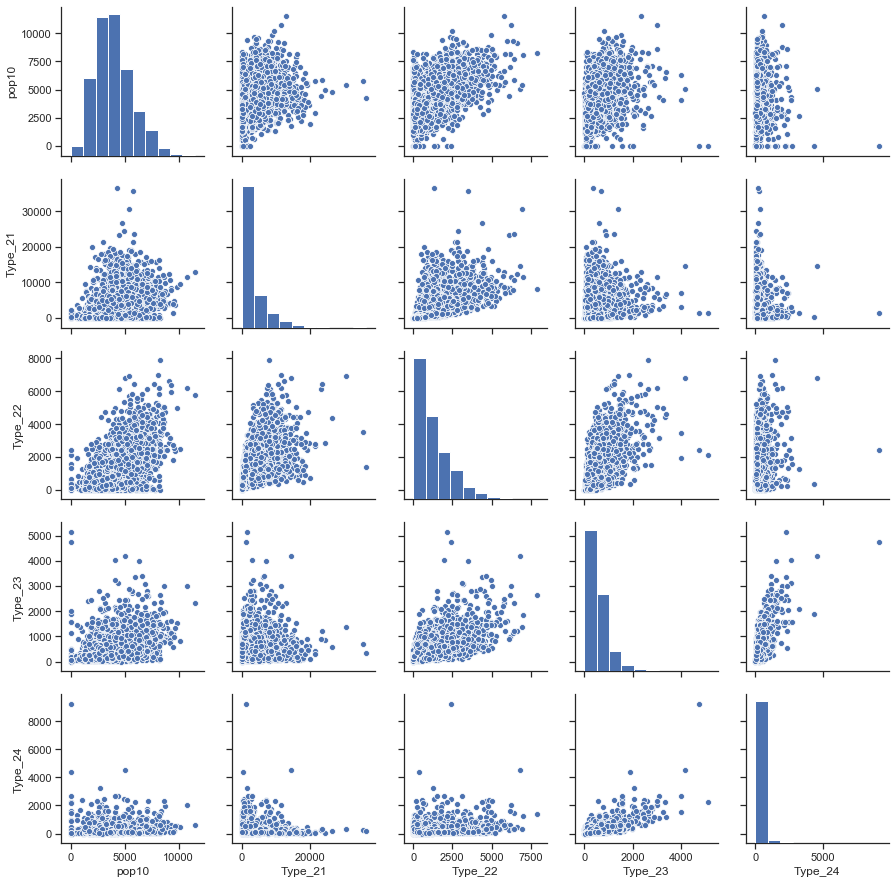

In [15]:
import seaborn as sns; sns.set(style = "ticks", color_codes = True)
sub_df = profiled_pa[['pop10', 'Type_21', 'Type_22', 'Type_23', 'Type_24']]
resulting_plot = sns.pairplot(sub_df)

The first row shows a positive relation with the population and the types selected. Now we fit a model using statsmodel:

In [16]:
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Poisson

weights = smf.glm('pop10 ~ -1 + Type_21 + Type_22 + Type_23 + Type_24', 
                  data = profiled_pa, 
                  family = Poisson()).fit().params
weights

Type_21    0.000107
Type_22    0.000978
Type_23    0.002815
Type_24   -0.002130
dtype: float64

We can see that for Type 24 the weights is negative in this case which might result in negative values for population in the pixel level. This is addressed through the function `return_weights_from_regression` that can input zero to these negative values through the argument `ReLU`. For more details, you can type `help(return_weights_from_regression)`.

*One alternative way to calculate the weights is to use `return_weights_from_xgboost`, instead of the regression approach.*